# **Practical session n°7** : Learning-to-Rank and Re-identification

**Part I:**

Several problems fall under the label "[learning-to-rank](https://link.springer.com/content/pdf/10.1007/978-3-642-15880-3_20.pdf)." One example is sorting a given list of labels (e.g. URL of websites) by relevance to an input query. This problem is referred to as *label ranking*.\
 In another scenario, input objects (e.g. images) should be sorted wrt a given criterion (e.g. 'foggy' or 'snowy'). Terms like *object ranking* and *learning to order things* are often used to describe this situation. In both cases, the learning is based on sorted samples, such as pairs of ordered images.

In this practical session, we illustrate the latter scenario using very simple synthetic images. All images consist of a mixture of a disc and a variable number of rectangles of different shapes. The goal is to sort the images based on the pixel intensity on the disc. To achieve this, we work in a standard context where we have pairs of ordered images. Using these pairs, we will train a neural network to construct a real-valued "ranking function" (*ranker*) whose outputs enable the sorting of images.

**Exercise #1:** Problem Construction

The following cells enable you to:
- generate a dataset on your drive (train+val and test),
- define a dataset that provides pairs of images and a comparison based on the criterion of disc intensity ("0" if the disc is more intense in the first image, "1" otherwise),
- visualize an initial batch.

In [5]:
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader, sampler

import matplotlib.pyplot as plt
import copy
from random import randint, choice



In [10]:
# imports from a git repo
! git clone https://github.com/relmonta/ml-student.git
os.chdir('ml-student/TP7')

#from archis import *
from utile_tp7_partI import *
#from train_and_test import *

root = r"/content"

Cloning into 'ml-student'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 355 (delta 108), reused 90 (delta 82), pack-reused 210
Receiving objects: 100% (355/355), 46.92 MiB | 30.41 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
dir_trainval = join(root, r"train")
generate_dataset(dir_trainval, size_dataset=10000)

dir_test = join(root, r"test")
generate_dataset(dir_test, size_dataset=2000)

In [13]:
# Retrieving target values

# Image paths:
dir_images_trainval = os.path.join(dir_trainval, 'images')
dir_images_test = os.path.join(dir_test, 'images')

# Target values for train+val
label_dict_path_trainval = os.path.join(dir_trainval, 'labels_synthese.pickle')
with open(label_dict_path_trainval, 'rb') as handle:
    label_dict_trainval = pickle.load(handle)

# Target values for test
label_dict_path_test = os.path.join(dir_test, 'labels_synthese.pickle')
with open(label_dict_path_test, 'rb') as handle:
    label_dict_test = pickle.load(handle)

# Splitting train / val (8000/2000)
all_image_names = np.array(ls(dir_images_trainval))

train_indices = list(range(0, 8000))
names_train = all_image_names[train_indices]
val_indices = list(range(8000, 10000))
names_val = all_image_names[val_indices]
names_test = ls(dir_images_test)

# Note: for random splitting, use sklearn.model_selection.train_test_split as tts

In [14]:
# Just in case:
# from shutil import rmtree
# rmtree(dir_test)

In [15]:
# Data Augmentation
class SuperFlip(object):
    """
    The 8 transformations
    generated by R(Pi/2) and vertical symmetry/axis
    """
    def __init__(self, num_transforms):
        self.num_transforms = num_transforms

    def __call__(self, image):
        # Note: Ideally, torch.randint should be used here...
        n = randint(0, self.num_transforms)
        if n == 1:
            image = image.flip([1])
        elif n == 2:
            image = image.flip([2])
        elif n == 3:
            image = image.transpose(1, 2)
        elif n == 4:
            image = image.transpose(1, 2).flip([1])
        elif n == 5:
            image = image.transpose(1, 2).flip([2])
        elif n == 6:
            image = image.flip([1, 2])
        elif n == 7:
            image = image.transpose(1, 2).flip([1, 2])
        return image

super_flip_transform = SuperFlip(8)

transforms = {
    'train': super_flip_transform,
    'val': None,
    'test': None
}

In [16]:
# Dataset Construction:
def oracle(name0, name1, data_dict):
    # Load the data:
    y0 = data_dict[name0]['y']
    y1 = data_dict[name1]['y']

    # Determine the comparison:
    compa = 0 if y1 < y0 else 1
    return compa

class DatasetOrderedPairs(torch.utils.data.Dataset):
    def __init__(self, images_dir, data_dict, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.imgs = ls(images_dir)
        self.data_dict = data_dict

    def __getitem__(self, idx):
        name0 = self.imgs[idx]
        name1 = choice(self.imgs)
        label = oracle(name0, name1, self.data_dict)

        # Get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 = torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array(label)).long(), name0, name1   # -1 if no class 0

    def __len__(self):
        return len(self.imgs)

In [76]:
# Dataset instantiation:
dataset_train = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['train'])
dataset_val = DatasetOrderedPairs(dir_images_trainval, label_dict_trainval, transforms['val'])
dataset_test = DatasetOrderedPairs(dir_images_test, label_dict_test, transforms['test'])

datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

In [77]:
# Samplers and loaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

samplers = {'train': train_sampler, 'val': val_sampler}

batch_size = 64

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}
dataloaders['test'] = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=0)
dataset_sizes = {'train': len(names_train), 'val': len(names_val), 'test': len(names_test)}

dataloaders['viz'] = torch.utils.data.DataLoader(datasets['train'], batch_size=6, shuffle=False, num_workers=0)

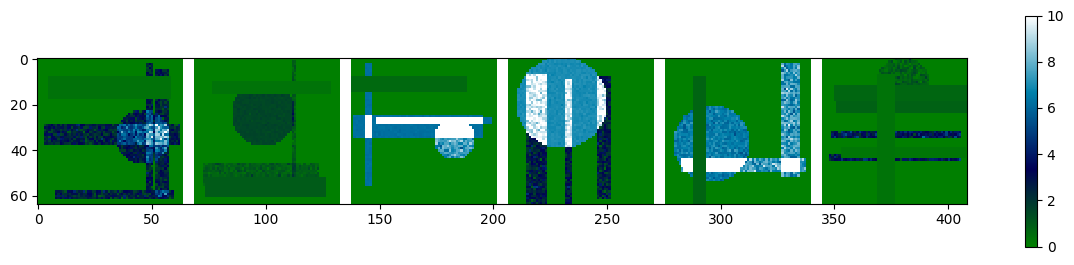

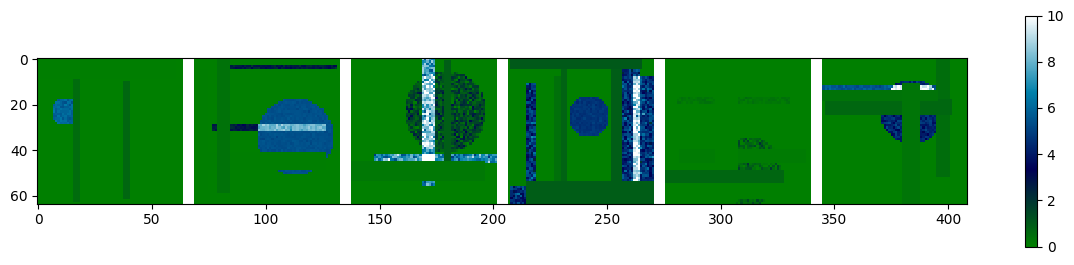

tensor([1, 1, 0, 0, 0, 1])


In [78]:
# Visualisation

img1, img2, labels, _, _ = next(iter(dataloaders['viz']))

fig0 = plt.figure(0, figsize=(15, 3))
voir_batch2D(img1, nx = 8, fig = fig0, k=0, min_scale=0,max_scale=10)
fig1 = plt.figure(1, figsize=(15, 3))
voir_batch2D(img2, nx = 8, fig = fig1, k=0, min_scale=0,max_scale=10)

print(labels)


**Q0** How is done the separation between training and validation done here?

Elle est faite au départ, dans la séparation entre le jeu d'entraînement et le jeu de test.

**Q1** What is the role of *super_flip*? And that of the *oracle* function?

SuperFlip permet de réaliser des transformations sur les images du jeu d'entraînement, afin d'augmenter sa dimension. Les transformations effectuées dans SuperFlip sont une combinaison de rotations d'angle π/2 et de symétrie verticale.

Oracle permet de comparer l'intensité du cercle de la paire d'images et de renvoyer la valeur 0 et 1.

**Q2** Are all pairs of images equally easy to order?

Non, des images avec des intensités proches vont être difficiles à ordonner, ou bien lorsque l'un des disques est obscur ou bruité.

**Exercise #2:** Siamese Learning

During training, batches of image pairs are compared. Basic siamese network training involves passing each image in the pair independently through the model and penalizing the model when the outputs are arranged in the wrong order.

The simplest way to do this is to consider the positive part of the difference between the outputs. This is what the following cost function does:

In [21]:
# Hinge Loss function

def label_to_sgn(label):  # 0 -> 1  and 1 -> -1
    sgn = torch.where(label == 0, 1, -1)
    return sgn

class HingeLoss(torch.nn.Module):
    def __init__(self, margin=0.1):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label):
        sgn = label_to_sgn(label)
        diff = sgn * (output1 - output0)

        loss = torch.relu(diff + self.margin).mean()
        return loss

**Q1** Write the training loop and run it for 20 epochs. Keep track of the successive accuracies.

In [46]:
num_epochs = 20
channels = 1

# With a ResNet18
from torchvision.models import resnet18
model = resnet18(num_classes=1)
model.conv1 =  nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Init the new conv layer
nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")


device = torch.device("cuda:0")
model = model.to(device)

criterion = HingeLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.002 )

# Loss function and optimizer
criterion = HingeLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [47]:
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.cuda()
            img2 = img2.cuda()
            labels = labels.cuda().detach()
            # TODO
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)

              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)
              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs.append(epoch_acc)


Epoch 1/50
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.1335 Acc: 0.6884


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1066 Acc: 0.7515
Epoch 2/50
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0532 Acc: 0.7954


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0578 Acc: 0.8090
Epoch 3/50
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0451 Acc: 0.8210


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0406 Acc: 0.8350
Epoch 4/50
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0379 Acc: 0.8446


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0352 Acc: 0.8610
Epoch 5/50
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0368 Acc: 0.8504


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0366 Acc: 0.8520
Epoch 6/50
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0352 Acc: 0.8602


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0358 Acc: 0.8695
Epoch 7/50
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0334 Acc: 0.8656


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0312 Acc: 0.8770
Epoch 8/50
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0308 Acc: 0.8782


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0323 Acc: 0.8705
Epoch 9/50
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0322 Acc: 0.8701


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0373 Acc: 0.8585
Epoch 10/50
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0297 Acc: 0.8794


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0290 Acc: 0.8845
Epoch 11/50
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0289 Acc: 0.8819


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0285 Acc: 0.8865
Epoch 12/50
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0307 Acc: 0.8710


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0337 Acc: 0.8590
Epoch 13/50
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0277 Acc: 0.8896


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0304 Acc: 0.8805
Epoch 14/50
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0300 Acc: 0.8776


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0252 Acc: 0.8995
Epoch 15/50
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0274 Acc: 0.8912


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0244 Acc: 0.9100
Epoch 16/50
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0268 Acc: 0.8971


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0252 Acc: 0.9030
Epoch 17/50
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0268 Acc: 0.8928


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0235 Acc: 0.9035
Epoch 18/50
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0267 Acc: 0.8940


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0284 Acc: 0.8860
Epoch 19/50
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0265 Acc: 0.8956


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0226 Acc: 0.9065
Epoch 20/50
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0265 Acc: 0.8964


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0248 Acc: 0.8985
Epoch 21/50
----------


Train Epoch 20:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0267 Acc: 0.8946


Val Epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0266 Acc: 0.8905
Epoch 22/50
----------


Train Epoch 21:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0252 Acc: 0.8992


Val Epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0235 Acc: 0.9045
Epoch 23/50
----------


Train Epoch 22:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0240 Acc: 0.9032


Val Epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0222 Acc: 0.9095
Epoch 24/50
----------


Train Epoch 23:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0257 Acc: 0.8979


Val Epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0332 Acc: 0.8780
Epoch 25/50
----------


Train Epoch 24:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0249 Acc: 0.8999


Val Epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0254 Acc: 0.8995
Epoch 26/50
----------


Train Epoch 25:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0241 Acc: 0.9067


Val Epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9175
Epoch 27/50
----------


Train Epoch 26:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0229 Acc: 0.9105


Val Epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0247 Acc: 0.9005
Epoch 28/50
----------


Train Epoch 27:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0234 Acc: 0.9111


Val Epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0232 Acc: 0.9090
Epoch 29/50
----------


Train Epoch 28:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0234 Acc: 0.9069


Val Epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 0.9145
Epoch 30/50
----------


Train Epoch 29:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0230 Acc: 0.9119


Val Epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0228 Acc: 0.9150
Epoch 31/50
----------


Train Epoch 30:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0232 Acc: 0.9077


Val Epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0224 Acc: 0.9120
Epoch 32/50
----------


Train Epoch 31:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0226 Acc: 0.9107


Val Epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0210 Acc: 0.9145
Epoch 33/50
----------


Train Epoch 32:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0212 Acc: 0.9140


Val Epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0192 Acc: 0.9285
Epoch 34/50
----------


Train Epoch 33:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0217 Acc: 0.9144


Val Epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0212 Acc: 0.9195
Epoch 35/50
----------


Train Epoch 34:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0213 Acc: 0.9156


Val Epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0214 Acc: 0.9195
Epoch 36/50
----------


Train Epoch 35:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0205 Acc: 0.9205


Val Epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0257 Acc: 0.9050
Epoch 37/50
----------


Train Epoch 36:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0206 Acc: 0.9174


Val Epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0196 Acc: 0.9185
Epoch 38/50
----------


Train Epoch 37:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0208 Acc: 0.9163


Val Epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0208 Acc: 0.9210
Epoch 39/50
----------


Train Epoch 38:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0210 Acc: 0.9156


Val Epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0199 Acc: 0.9205
Epoch 40/50
----------


Train Epoch 39:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9189


Val Epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0233 Acc: 0.9085
Epoch 41/50
----------


Train Epoch 40:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0206 Acc: 0.9201


Val Epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 0.9200
Epoch 42/50
----------


Train Epoch 41:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0221 Acc: 0.9147


Val Epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0175 Acc: 0.9375
Epoch 43/50
----------


Train Epoch 42:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0208 Acc: 0.9186


Val Epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0180 Acc: 0.9290
Epoch 44/50
----------


Train Epoch 43:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0191 Acc: 0.9251


Val Epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0183 Acc: 0.9310
Epoch 45/50
----------


Train Epoch 44:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9170


Val Epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0169 Acc: 0.9335
Epoch 46/50
----------


Train Epoch 45:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0198 Acc: 0.9226


Val Epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0202 Acc: 0.9235
Epoch 47/50
----------


Train Epoch 46:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0187 Acc: 0.9305


Val Epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0237 Acc: 0.9105
Epoch 48/50
----------


Train Epoch 47:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0188 Acc: 0.9269


Val Epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0220 Acc: 0.9130
Epoch 49/50
----------


Train Epoch 48:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0194 Acc: 0.9254


Val Epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0195 Acc: 0.9235
Epoch 50/50
----------


Train Epoch 49:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0200 Acc: 0.9207


Val Epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0139 Acc: 0.9490


**Q3** Check the learning curve.

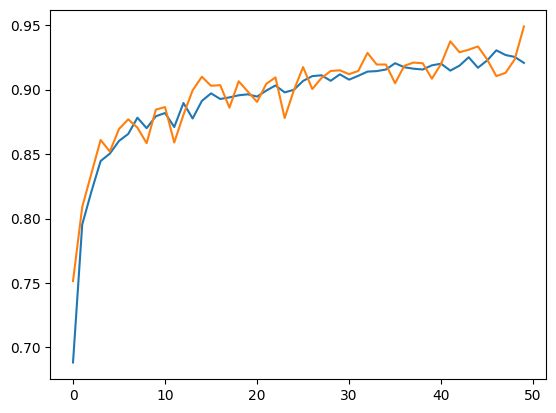

In [48]:
plt.plot(train_accs)
plt.plot(val_accs)

**Q4** Interprete the following scatterplot:

Text(0, 0.5, '$\\hat{y}$')

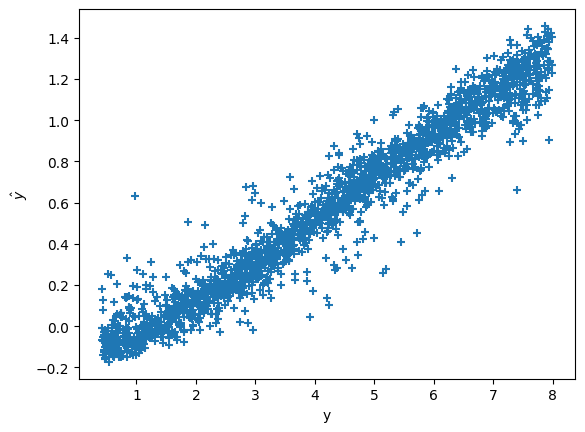

In [49]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats.append(yhat)

# make np array
ys = np.array(ys)
yhats = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


En abscisse, vraie valeur de l'intensité du disque. En ordonnée, valeur estimée qui varie avec l'intensité.

Le but est que la courbe soit strictement croissante, ça n'est pas nécessairement une droite, ça peut prendre la forme d'une sigmoïde.

**Q5** Calculate the Spearman and Kendall rank correlations. Which of the two is related to the accuracy measure?


In [50]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau

#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(ys, yhats)

print('Spearman Rank coorelation: %.5f' % rho)

# Calculating Kendall Rank correlation
corr, _ = kendalltau(ys, yhats)
print('Kendall Rank correlation: %.5f' % corr)

Spearman Rank coorelation: 0.97391
Kendall Rank correlation: 0.86386


Corrélations de rang : bon score pour représenter si une relation est univoque (courbe strictement croissante).
Différence: Avec Spearman, on va chercher la corrélation au niveau des rangs et non au niveau des images elles-mêmes.
Avec Kendall, c'est basé sur des paires comparées. Ratio de paires correctement comparées sur le nombre de paires à comparer. Très proche du calcul de l'accuracy.

**Q6** We extend the training to 50 epochs. Load the following checkpoint, revisit questions 4 and 5 with this model, and provide comments.

In [51]:
os.chdir('/content')
! wget https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
PATH_checkpoint = './WUuEwrxaf65_vySRhNAbepk'

--2023-12-22 08:58:29--  https://www.grosfichiers.com/WUuEwrxaf65_vySRhNAbepk
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134182874 (128M) [application/octet-stream]
Saving to: ‘WUuEwrxaf65_vySRhNAbepk.1’

WUuEwrxaf65_vySRhNA 100%[===================>] 127.97M  14.8MB/s    in 9.4s    

2023-12-22 08:58:40 (13.6 MB/s) - ‘WUuEwrxaf65_vySRhNAbepk.1’ saved [134182874/134182874]



**Q7** How would you improve performance?

Curriculum Learning:
- Seek more "challenging" pairs towards the end of training.

Optimization:
- Consider adding a learning rate scheduler.

Other Loss Functions:
- Explore RankNet loss.
- Explore Listnet Loss.

**Exercice #3** Curriculum Learning

One idea is to make the problem harder after an initial training phase. The following code allows you to retrieve a ResNet18 trained for 50 epochs, the optimizer, and the associated learning curve:

**Q1** Take the ResNet18 trained on 50 epochs. Continue training for an additional 20 epochs without changing the dataloader. Remember to store accuracies related to the validation set and outputs related to the test set.

In [79]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=False, sampler=samplers[x], num_workers=2) for x in ['train', 'val']}

In [80]:
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding = 3, bias=False)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH_checkpoint)
print(checkpoint.keys())

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
val_accs_standard = checkpoint['val_accs']

dict_keys(['val_accs', 'model', 'optimizer'])


In [81]:
best_control_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 20
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.cuda()
            img2 = img2.cuda()
            labels = labels.cuda().detach()
            # TODO
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)

              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)
              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs_standard.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0187 Acc: 0.9255


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9295
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0199 Acc: 0.9257


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9285
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 0.9209


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0191 Acc: 0.9275
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0198 Acc: 0.9249


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0170 Acc: 0.9345
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0177 Acc: 0.9311


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0185 Acc: 0.9300
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0190 Acc: 0.9271


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0175 Acc: 0.9335
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0192 Acc: 0.9237


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0165 Acc: 0.9400
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0174 Acc: 0.9326


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0181 Acc: 0.9315
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0168 Acc: 0.9373


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0153 Acc: 0.9425
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0172 Acc: 0.9333


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0158 Acc: 0.9405
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9289


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0179 Acc: 0.9285
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0182 Acc: 0.9287


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0200 Acc: 0.9250
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0179 Acc: 0.9275


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 0.9310
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0178 Acc: 0.9309


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0164 Acc: 0.9420
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0173 Acc: 0.9335


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0184 Acc: 0.9315
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0169 Acc: 0.9339


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0162 Acc: 0.9445
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0161 Acc: 0.9379


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0169 Acc: 0.9395
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0175 Acc: 0.9309


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0145 Acc: 0.9495
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0172 Acc: 0.9326


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0162 Acc: 0.9395
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0168 Acc: 0.9339


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0157 Acc: 0.9390


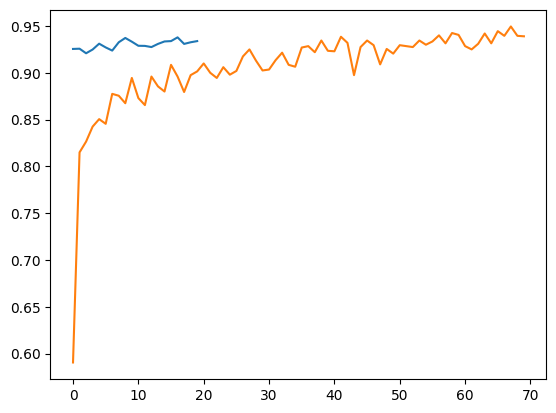

In [84]:
plt.plot(train_accs)
plt.plot(val_accs_standard)

Text(0, 0.5, '$\\hat{y}$')

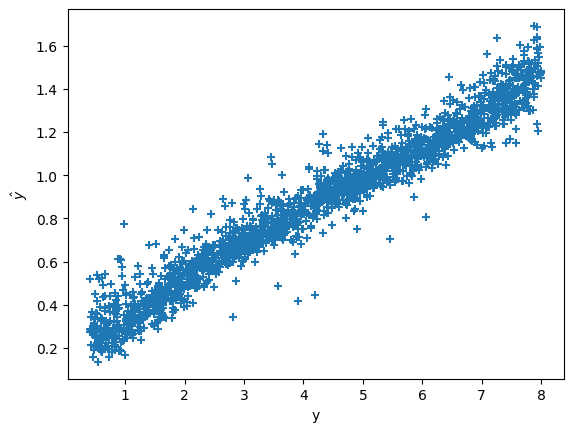

In [85]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats_control = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats_control.append(yhat)

# make np array
ys = np.array(ys)
yhats_control = np.array(yhats_control)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats_control, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Q2** We will now continue training on pairs that are harder to order. For this purpose, we have the 'Dataset_finer_pairs' dataset below. Train for 20 epochs using this dataset (use epoch_ray = 1.).

In [86]:
def make_dic_ray(imgs, dic, ray):

  ys = np.array([dic[img]['y'] for img in imgs])
  imgs = np.array(imgs)
  dic_ray = {}
  for i,img in enumerate(imgs):
    y = ys[i]
    # on limite la paire à des disques proches en intensité
    dic_ray[img] = list(imgs[np.abs(ys - y) < ray])

  return dic_ray

class Dataset_finer_pairs(torch.utils.data.Dataset):
    def __init__(self, images_dir,  dic, transfo = None, ray=0.5):
        self.images_dir = images_dir
        self.transfo = transfo
        self.imgs = sorted(ls(images_dir))
        self.dic = dic
        self.dic_ray = make_dic_ray(self.imgs, dic, ray)

    def __getitem__(self,idx):

        name0 = self.imgs[idx]
        name1 = choice(self.dic_ray[name0])
        label = oracle(name0, name1, self.dic)


        #get the images
        path0 = os.path.join(self.images_dir, name0)
        img0 =  torch.load(path0)
        path1 = os.path.join(self.images_dir, name1)
        img1 = torch.load(path1)


        if self.transfo is not None:
            img0 = self.transfo(img0)
            img1 = self.transfo(img1)

        return img0, img1,  torch.from_numpy(np.array(label)).long(), name0, name1

    def __len__(self):
        return len(self.imgs)

In [87]:
# Dataset instantiation:
epoch_ray = 1
dataset_train = Dataset_finer_pairs(dir_images_trainval, label_dict_trainval, transforms['train'], ray = epoch_ray)

dataloaders['train'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler=samplers['train'], num_workers=2)

In [88]:
model = resnet18(num_classes=1)
model.conv1 = nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding = 3, bias=False)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(PATH_checkpoint)
print(checkpoint.keys())

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
val_accs_curriculum = checkpoint['val_accs']

dict_keys(['val_accs', 'model', 'optimizer'])


In [89]:
best_control_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 20
from tqdm import tqdm, notebook

train_accs = []
val_accs = []

phases = ['train', 'val']

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in phases:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        data_loader = notebook.tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave= phase == 'train')
        # Iterate over data.
        for img1, img2, labels, _, _ in data_loader:

            img1 = img1.cuda()
            img2 = img2.cuda()
            labels = labels.cuda().detach()
            # TODO
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
              output1 = model(img1)
              output2 = model(img2)

              _, preds = torch.max(torch.cat((output1, output2), dim=1), 1)
              loss = criterion(output1, output2, labels.to(torch.float32).unsqueeze(dim=1))

              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * img1.size(0)
            running_corrects += torch.sum(preds == labels.data).double().item()

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_accs.append(epoch_acc)

        if phase == 'val':
            val_accs_curriculum.append(epoch_acc)


Epoch 1/20
----------


Train Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0672 Acc: 0.7319


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0179 Acc: 0.9335
Epoch 2/20
----------


Train Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0648 Acc: 0.7456


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0196 Acc: 0.9280
Epoch 3/20
----------


Train Epoch 2:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0605 Acc: 0.7588


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0198 Acc: 0.9325
Epoch 4/20
----------


Train Epoch 3:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0612 Acc: 0.7658


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0166 Acc: 0.9395
Epoch 5/20
----------


Train Epoch 4:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0587 Acc: 0.7719


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0158 Acc: 0.9445
Epoch 6/20
----------


Train Epoch 5:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0571 Acc: 0.7836


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0198 Acc: 0.9320
Epoch 7/20
----------


Train Epoch 6:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0577 Acc: 0.7746


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0156 Acc: 0.9450
Epoch 8/20
----------


Train Epoch 7:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0556 Acc: 0.7904


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0182 Acc: 0.9380
Epoch 9/20
----------


Train Epoch 8:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0545 Acc: 0.7927


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0176 Acc: 0.9385
Epoch 10/20
----------


Train Epoch 9:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0538 Acc: 0.7926


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0136 Acc: 0.9465
Epoch 11/20
----------


Train Epoch 10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0548 Acc: 0.7875


Val Epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0155 Acc: 0.9490
Epoch 12/20
----------


Train Epoch 11:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0523 Acc: 0.8030


Val Epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0150 Acc: 0.9510
Epoch 13/20
----------


Train Epoch 12:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0520 Acc: 0.8005


Val Epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0126 Acc: 0.9570
Epoch 14/20
----------


Train Epoch 13:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0514 Acc: 0.8057


Val Epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0153 Acc: 0.9475
Epoch 15/20
----------


Train Epoch 14:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0505 Acc: 0.8025


Val Epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0154 Acc: 0.9450
Epoch 16/20
----------


Train Epoch 15:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0502 Acc: 0.8029


Val Epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0148 Acc: 0.9440
Epoch 17/20
----------


Train Epoch 16:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0491 Acc: 0.8131


Val Epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0128 Acc: 0.9560
Epoch 18/20
----------


Train Epoch 17:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0476 Acc: 0.8187


Val Epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0155 Acc: 0.9445
Epoch 19/20
----------


Train Epoch 18:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0488 Acc: 0.8099


Val Epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0116 Acc: 0.9570
Epoch 20/20
----------


Train Epoch 19:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0490 Acc: 0.8129


Val Epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0125 Acc: 0.9580


**Q3** Why is the training accuracy lower than before? Compare the learning curves (validation accuracies) and the results on the test set. Discuss.

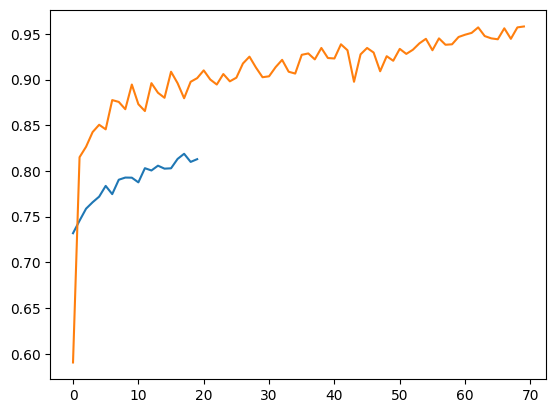

In [90]:
plt.plot(train_accs)
plt.plot(val_accs_curriculum)

Text(0, 0.5, '$\\hat{y}$')

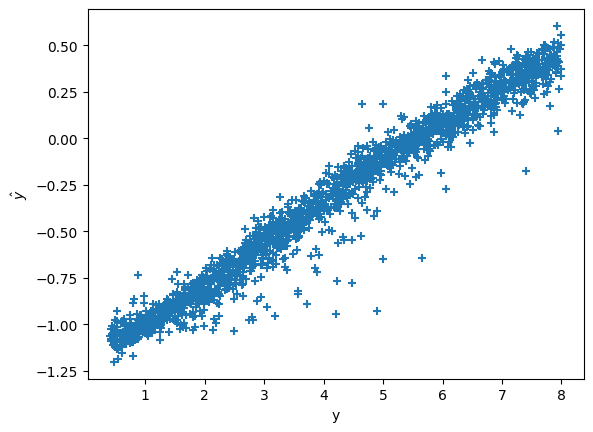

In [91]:
# true (mean) pixel intensity on the disk:
ys = []
# outputs of the network:
yhats_curriculum = []

# browse the test set:
for name in names_test:
    # get true mean intensity on the disk
    y = label_dict_test[name]['y']
    ys.append(y)

    path = join(dir_images_test, name)
    image = torch.load(path)
    image = image.cuda().unsqueeze(dim=0)

    # get model output
    yhat = model.eval()(image)
    yhat = yhat.item()
    yhats_curriculum.append(yhat)

# make np array
ys = np.array(ys)
yhats_curriculum = np.array(yhats)

# scatterplot
plt.figure(num=10)
plt.scatter(ys, yhats_curriculum, marker='+')
plt.xlabel('y')
plt.ylabel('$\hat{y}$')


**Exercise #4** RankNet Loss (and ListNet Loss)

A milder version of the Hinge Loss has been widely used, particularly in search engine learning, known as the RankNet Loss.

This cost function is derived from a parametric probabilistic model, the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model).

In a general version, it is assumed that the outcome of a comparison (or match) between two objects "0" and "1" (or two teams) is random and depends on real values associated with the objects (the "team levels") as follows:
\begin{align}
P_0 = \dfrac{f(y_0)}{f(y_0) + f(y_1)}
\tag{1}
\end{align}
Where $P_0$ is the probability of choosing object "0" (or the first team winning), and $f$ is a strictly increasing function with positive values.

**Q1** In the case where $f(y) = e^{\sigma y}$, what do the choice probabilities depend on? Write the log-likelihood of the event "object $x$ is chosen."

**Q2** Derive an appropriate cost function for our ranking problem based on the given log-likelihood.

**Q3** Implement and compare over twenty epochs.